In [1]:
! pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=c957622cbd29e50ca4fc6c2f0db34358ea72c56e07a35a1d9190ac83e9a8fd53
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import random
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [4]:
class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [5]:
def create_model(num_classes, input_shape=(28, 28, 1)):
    model = Sequential([
        Conv2D(25, (4,4), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(111, (4,4), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(123, (4,4), activation='relu'),
        Flatten(),
        Dense(102, activation='relu'),
        Dropout(0.3619968138672127),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [6]:
def filter_data_by_classes(X, y, classes):
    # Ensure that y is flattened if it's not already
    if y.ndim > 1:
        y = y.flatten()
    filter_mask = np.isin(y, classes)
    return X[filter_mask], y[filter_mask]




In [7]:
def incremental_learning_separate(model, replay_buffer, batch_size, epochs, train_histories, new_data, X_val, y_val):
    for i in range(len(new_data[0])):
        replay_buffer.push((new_data[0][i], new_data[1][i]))

    if len(replay_buffer) >= replay_buffer.capacity:
        print("Warning: Replay buffer is at full capacity!")

    if len(replay_buffer) >= batch_size:
        batch = replay_buffer.sample(batch_size)
        X_replay, y_replay = zip(*batch)
        X_replay = np.array(X_replay)
        y_replay = np.array(y_replay)
    else:
        print(f"Using smaller replay batch of size {len(replay_buffer)}.")
        batch_size = len(replay_buffer)
        batch = replay_buffer.sample(batch_size)
        X_replay, y_replay = zip(*batch)
        X_replay = np.array(X_replay)
        y_replay = np.array(y_replay)

    X_train_combined = np.concatenate((X_replay, new_data[0]), axis=0) if len(X_replay) > 0 else new_data[0]
    y_train_combined = np.concatenate((y_replay, new_data[1]), axis=0) if len(y_replay) > 0 else new_data[1]

    indices = np.arange(X_train_combined.shape[0])
    np.random.shuffle(indices)
    X_train_combined = X_train_combined[indices]
    y_train_combined = y_train_combined[indices]

    for epoch in range(epochs):
#         print(f'Epoch {epoch + 1}/{epochs} started (new class added)')
        try:
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

            class_weights = compute_class_weight(
                class_weight='balanced', 
                classes=np.unique(y_train_combined), 
                y=y_train_combined
            )
            class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

            history_replay = model.fit(X_train_combined, y_train_combined, batch_size=batch_size, epochs=epochs, 
                                       validation_data=(X_val, y_val), class_weight=class_weight_dict, 
                                       callbacks=[early_stopping])
            train_histories.append(history_replay.history)
            return history_replay
        except Exception as e:
            print(f"Error during training: {e}")


In [8]:
def extend_output_layer(model, new_num_classes):
    model_layers = [layer for layer in model.layers[:-1]]  # Remove the last layer (output layer)
    
    new_model = Sequential(model_layers)
    new_model.add(Dense(new_num_classes, activation='softmax'))  # Add a new output layer
    
    for i in range(len(new_model.layers)-1):
        new_model.layers[i].set_weights(model.layers[i].get_weights())  # Retain weights from original model
    
    new_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    
    return new_model


In [9]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy', color='b', marker='o')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='g', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss', color='b', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', color='g', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


In [10]:
def evaluate_model_on_test(model, X_test, y_test, task_num):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print(f"\nClassification report for Task {task_num}:")
    print(classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in np.unique(y_test)]))


<h1> Get Data and Preprocess

In [11]:
from medmnist import PathMNIST

train = PathMNIST(split='train', download=True)
val = PathMNIST(split='val', download=True)

100%|██████████| 205615438/205615438 [00:16<00:00, 12489280.83it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [12]:
X_train, y_train = train.imgs, train.labels
X_val, y_val = val.imgs, val.labels

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [13]:
print("Number of images in training set:", len(X_train))
print("Number of images in validation set:", len(X_val))
print("Number of images in test set:", len(X_test))
print("Total : ",len(X_train)+len(X_val)+len(X_test))

Number of images in training set: 71996
Number of images in validation set: 10004
Number of images in test set: 18000
Total :  100000


Shape of first image: (28, 28, 3)


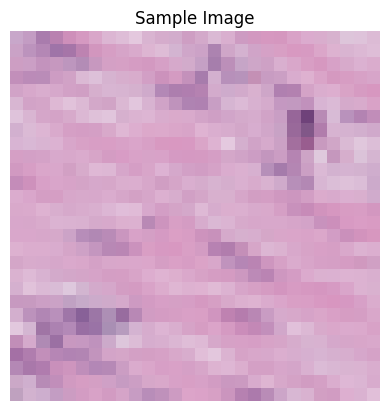

In [14]:
import matplotlib.pyplot as plt

# Remove unnecessary dimension (e.g., from (28, 28, 3, 1) to (28, 28, 3))
X_train = np.squeeze(X_train)

# Check the shape of the first image in the training set
print(f"Shape of first image: {X_train[0].shape}")

# Display the first image
plt.imshow(X_train[0])
plt.title("Sample Image")
plt.axis("off")  # Turn off axis labels
plt.show()


In [15]:
X_train = np.squeeze(X_train)
X_val = np.squeeze(X_val)
X_test = np.squeeze(X_test)

# Convert images to grayscale by averaging the RGB channels
X_train = np.mean(X_train, axis=-1, keepdims=True)
X_val = np.mean(X_val, axis=-1, keepdims=True)
X_test = np.mean(X_test, axis=-1, keepdims=True)

In [16]:
print(f"Shape of grayscale image in X_train: {X_train.shape}")
print(f"Shape of grayscale image in X_val: {X_val.shape}")
print(f"Shape of grayscale image in X_test: {X_test.shape}")

Shape of grayscale image in X_train: (71996, 28, 28, 1)
Shape of grayscale image in X_val: (10004, 28, 28, 1)
Shape of grayscale image in X_test: (18000, 28, 28, 1)


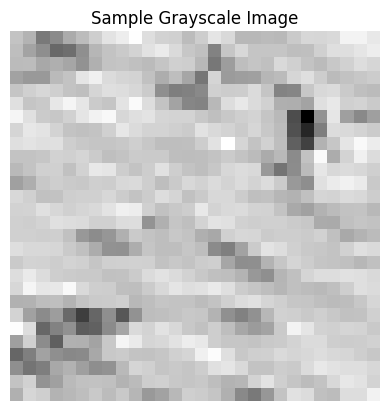

In [17]:
plt.imshow(X_train[0].squeeze(), cmap='gray')
plt.title("Sample Grayscale Image")
plt.axis("off")
plt.show()

In [18]:

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


In [19]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (71996, 28, 28, 1)
Shape of X_val: (10004, 28, 28, 1)
Shape of X_test: (18000, 28, 28, 1)


In [21]:
def add_noise(X, noise_factor=0.2):
    noise = np.random.normal(loc=0.0, scale=10.0, size=X.shape)
    noisy_X = X + noise_factor * noise
    return np.clip(noisy_X, 0., 1.)


<h1> Task 1

In [36]:
num_classes = 2
model1 = create_model(num_classes)
replay_buffer = ExperienceReplay(capacity=1000000)
train_histories = []

In [37]:
X_train_2, y_train_2 = filter_data_by_classes(X_train, y_train, [0, 1])
X_val_2, y_val_2 = filter_data_by_classes(X_val, y_val, [0, 1])
X_test_2, y_test_2 = filter_data_by_classes(X_test, y_test, [0,1])


In [38]:
X_train_2 = add_noise(X_train_2,0.2)
X_val_2 = add_noise(X_val_2,0.2)
X_test_2 = add_noise(X_test_2,0.2)

In [39]:
print("Training on 2 classes (0,1)...")
model1_history = incremental_learning_separate(model1, replay_buffer, batch_size=32, epochs=10, 
                                         train_histories=train_histories, new_data=(X_train_2, y_train_2), 
                                         X_val=X_val_2, y_val=y_val_2)

Training on 2 classes (0,1)...
Epoch 1/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6476 - loss: 0.5934 - val_accuracy: 0.7788 - val_loss: 0.4641
Epoch 2/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7827 - loss: 0.4630 - val_accuracy: 0.7707 - val_loss: 0.4726
Epoch 3/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7856 - loss: 0.4603 - val_accuracy: 0.7946 - val_loss: 0.4405
Epoch 4/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7960 - loss: 0.4388 - val_accuracy: 0.7817 - val_loss: 0.4679
Epoch 5/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8037 - loss: 0.4285 - val_accuracy: 0.7989 - val_loss: 0.4376
Epoch 6/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7997 - loss: 0.4292 - val_accuracy: 0.7989 - val_loss: 0.4439
Epoch 7/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8158 - loss: 0.4113 - val_accuracy: 0.7655 - val_loss: 0.4767
Epoch 8/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8133 -

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification report for Task 1:
              precision    recall  f1-score   support

     Class 0       0.72      0.95      0.82      1840
     Class 1       0.93      0.66      0.77      2006

    accuracy                           0.80      3846
   macro avg       0.82      0.80      0.79      3846
weighted avg       0.83      0.80      0.79      3846



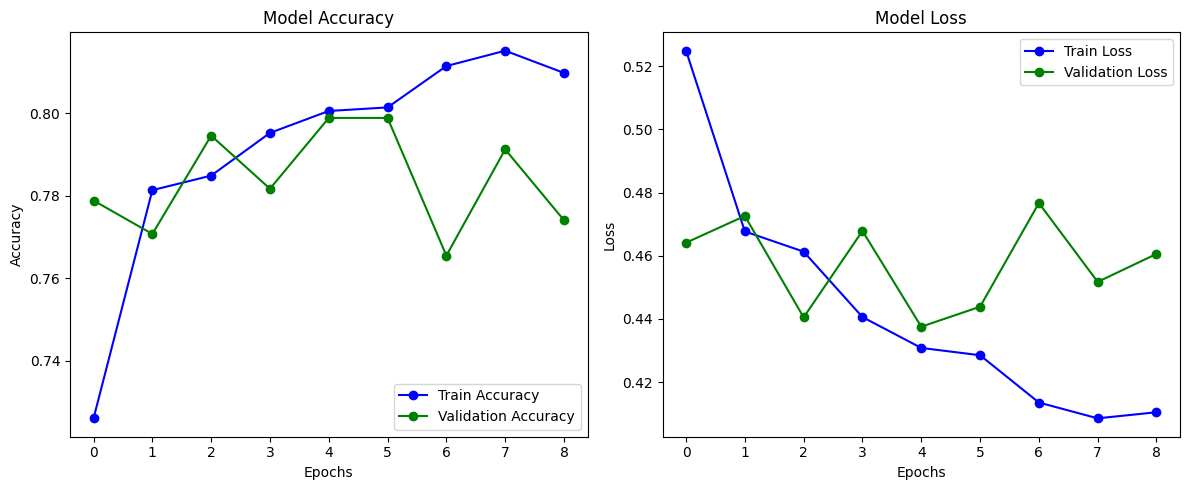

In [40]:
# Evaluate model
evaluate_model_on_test(model1, X_test_2, y_test_2, task_num=1)

# Plot training history
plot_accuracy_loss(model1_history.history)

In [41]:
X_train_01, y_train_01 = filter_data_by_classes(X_train, y_train, [0,1])

for i in range(len(X_train_01)):
    replay_buffer.push((X_train_01[i], y_train_01[i]))

In [42]:
train_histories.append(model1_history)

<h1> Task 2

In [62]:
num_classes = 3  # Introducing the third class
model2 = extend_output_layer(model1, num_classes)

X_train_3, y_train_3 = filter_data_by_classes(X_train, y_train, [0,1,2])
X_val_3, y_val_3 = filter_data_by_classes(X_val, y_val, [0,1,2])
X_test_3, y_test_3 = filter_data_by_classes(X_test, y_test, [0,1,2])

In [63]:
X_train_3 = add_noise(X_train_3,0.07)
X_val_3 = add_noise(X_val_3,0.07)
X_test_3 = add_noise(X_test_3,0.07)

In [64]:
print("New class added class 2")
model2_history = incremental_learning_separate(model2, replay_buffer, batch_size=32, epochs=10, 
                                         train_histories=train_histories, new_data=(X_train_3, y_train_3), 
                                         X_val=X_val_3, y_val=y_val_3)

New class added class 2
Epoch 1/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7236 - loss: 0.6860 - val_accuracy: 0.8052 - val_loss: 0.5173
Epoch 2/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8103 - loss: 0.5191 - val_accuracy: 0.8083 - val_loss: 0.5069
Epoch 3/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8088 - loss: 0.5240 - val_accuracy: 0.7735 - val_loss: 0.5825
Epoch 4/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8122 - loss: 0.5126 - val_accuracy: 0.8172 - val_loss: 0.4834
Epoch 5/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8170 - loss: 0.5006 - val_accuracy: 0.8154 - val_loss: 0.4904
Epoch 6/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8226 - loss: 0.4903 - val_accuracy: 0.8218 - val_loss: 0.4800
Epoch 7/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8193 - loss: 0.4939 - val_accuracy: 0.8157 - val_loss: 0.4997
Epoch 8/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8290 - loss: 0

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification report for Task 2:
              precision    recall  f1-score   support

     Class 0       0.75      0.90      0.82      1840
     Class 1       0.91      0.67      0.77      2006
     Class 2       0.80      0.87      0.84      1994

    accuracy                           0.81      5840
   macro avg       0.82      0.81      0.81      5840
weighted avg       0.82      0.81      0.81      5840



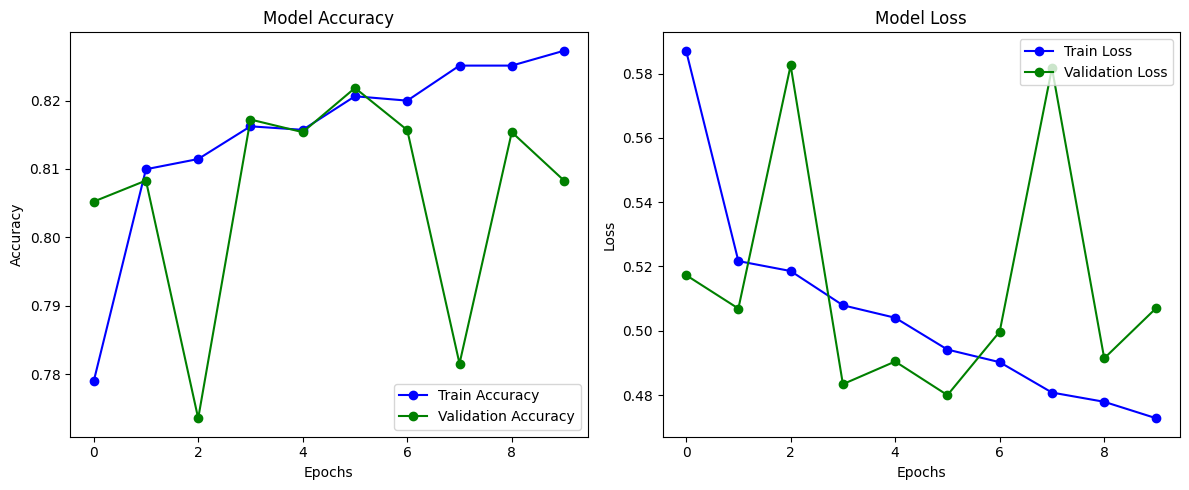

In [65]:
# Evaluate model
evaluate_model_on_test(model2, X_test_3, y_test_3, task_num=2)

# Plot training history
plot_accuracy_loss(model2_history.history)

In [66]:
X_train_2, y_train_2 = filter_data_by_classes(X_train, y_train, [2])

for i in range(len(X_train_2)):
    replay_buffer.push((X_train_2[i], y_train_2[i]))

In [67]:
train_histories.append(model2_history)

<h1> Task 3

In [91]:
num_classes = 4  # Introducing the third class
model3 = extend_output_layer(model2, num_classes)

X_train_4, y_train_4 = filter_data_by_classes(X_train, y_train, [0,1,2,3])
X_val_4, y_val_4 = filter_data_by_classes(X_val, y_val, [0,1,2,3])
X_test_4, y_test_4 = filter_data_by_classes(X_test, y_test, [0,1,2,3])

In [92]:
X_train_4 = add_noise(X_train_4,0.01)
X_val_4 = add_noise(X_val_4,0.01)
X_test_4 = add_noise(X_test_4,0.01)

In [93]:
print("New class added class 3")
model3_history = incremental_learning_separate(model3, replay_buffer, batch_size=32, epochs=10, 
                                         train_histories=train_histories, new_data=(X_train_4, y_train_4), 
                                         X_val=X_val_4, y_val=y_val_4)

New class added class 3
Epoch 1/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7102 - loss: 0.7208 - val_accuracy: 0.8066 - val_loss: 0.4542
Epoch 2/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8088 - loss: 0.4695 - val_accuracy: 0.8130 - val_loss: 0.4574
Epoch 3/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8109 - loss: 0.4504 - val_accuracy: 0.8182 - val_loss: 0.4488
Epoch 4/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8240 - loss: 0.4247 - val_accuracy: 0.8320 - val_loss: 0.4182
Epoch 5/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8258 - loss: 0.4126 - val_accuracy: 0.8261 - val_loss: 0.4231
Epoch 6/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8317 - loss: 0.4025 - val_accuracy: 0.8366 - val_loss: 0.4026
Epoch 7/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8342 - loss: 0.4002 - val_accuracy: 0.8239 - val_loss: 0.4195
Epoch 8/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8371 - loss: 0

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification report for Task 3:
              precision    recall  f1-score   support

     Class 0       0.89      0.97      0.93      1840
     Class 1       0.93      0.80      0.86      2006
     Class 2       0.77      0.67      0.72      1994
     Class 3       0.78      0.92      0.84      2071

    accuracy                           0.84      7911
   macro avg       0.84      0.84      0.84      7911
weighted avg       0.84      0.84      0.84      7911



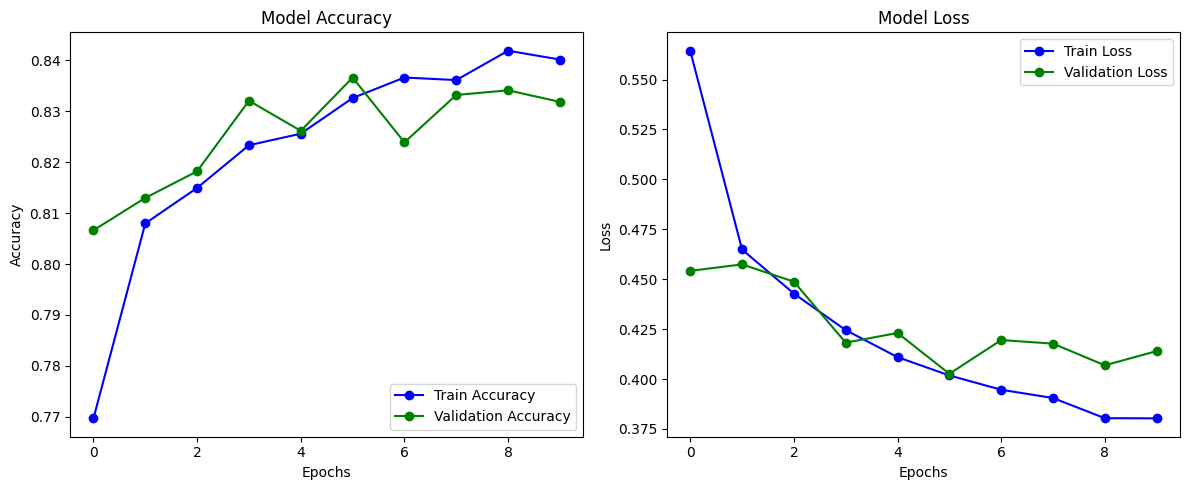

In [94]:
# Evaluate model
evaluate_model_on_test(model3, X_test_4, y_test_4, task_num=3)

# Plot training history
plot_accuracy_loss(model3_history.history)

In [95]:
X_train_3, y_train_3 = filter_data_by_classes(X_train, y_train, [3])

for i in range(len(X_train_3)):
    replay_buffer.push((X_train_3[i], y_train_3[i]))

In [96]:
train_histories.append(model3_history)

<h1> Task 4

In [97]:
num_classes = 5  # Introducing the third class
model4 = extend_output_layer(model3, num_classes)

X_train_5, y_train_5 = filter_data_by_classes(X_train, y_train, [0,1,2,3,4])
X_val_5, y_val_5 = filter_data_by_classes(X_val, y_val, [0,1,2,3,4])
X_test_5, y_test_5 = filter_data_by_classes(X_test, y_test, [0,1,2,3,4])

In [98]:
print("New class added class 4")
model4_history = incremental_learning_separate(model4, replay_buffer, batch_size=32, epochs=10, 
                                         train_histories=train_histories, new_data=(X_train_5, y_train_5), 
                                         X_val=X_val_5, y_val=y_val_5)

New class added class 4
Epoch 1/10
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7126 - loss: 0.7831 - val_accuracy: 0.8444 - val_loss: 0.4110
Epoch 2/10
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8380 - loss: 0.4416 - val_accuracy: 0.8529 - val_loss: 0.3932
Epoch 3/10
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8491 - loss: 0.4133 - val_accuracy: 0.8465 - val_loss: 0.3912
Epoch 4/10
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8556 - loss: 0.3899 - val_accuracy: 0.8425 - val_loss: 0.3930
Epoch 5/10
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8568 - loss: 0.3765 - val_accuracy: 0.8510 - val_loss: 0.3944
Epoch 6/10
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8674 - loss: 0.3480 - val_accuracy: 0.8523 - val_loss: 0.3736


1193/1193 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification report for Task 4:
              precision    recall  f1-score   support

     Class 0       0.87      0.96      0.91      7526
     Class 1       0.90      0.92      0.91      7503
     Class 2       0.89      0.63      0.74      8366
     Class 3       0.87      0.97      0.92      8330
     Class 4       0.77      0.84      0.80      6423

    accuracy                           0.86     38148
   macro avg       0.86      0.86      0.86     38148
weighted avg       0.86      0.86      0.86     38148



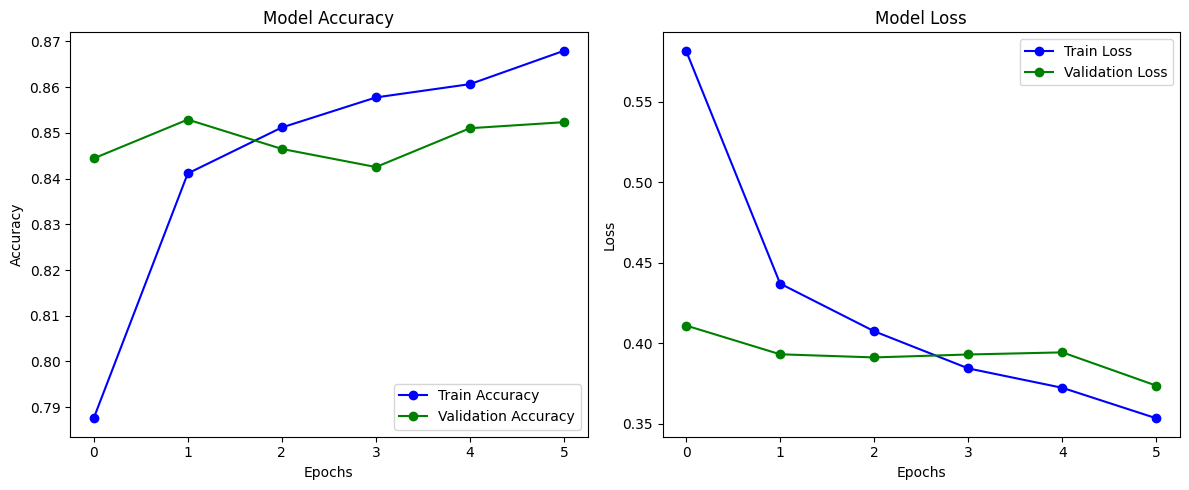

In [99]:
# Evaluate model
evaluate_model_on_test(model4, X_train_5, y_train_5, task_num=4)

# Plot training history
plot_accuracy_loss(model4_history.history)

In [108]:
X_train_4, y_train_4 = filter_data_by_classes(X_train, y_train, [4])

for i in range(len(X_train_4)):
    replay_buffer.push((X_train_4[i], y_train_4[i]))

In [110]:
train_histories.append(model4_history)

<h1> Task 5

In [101]:
num_classes = 6  # Introducing the third class
model5 = extend_output_layer(model4, num_classes)

X_train_6, y_train_6 = filter_data_by_classes(X_train, y_train, [0,1,2,3,4,5])
X_val_6, y_val_6 = filter_data_by_classes(X_val, y_val, [0,1,2,3,4,5])
X_test_6, y_test_6 = filter_data_by_classes(X_test, y_test, [0,1,2,3,4,5])

In [102]:
print("New class added class 5")
model5_history = incremental_learning_separate(model5, replay_buffer, batch_size=32, epochs=20, 
                                         train_histories=train_histories, new_data=(X_train_6, y_train_6), 
                                         X_val=X_val_6, y_val=y_val_6)

New class added class 5
Epoch 1/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6142 - loss: 0.9776 - val_accuracy: 0.7511 - val_loss: 0.6180
Epoch 2/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7327 - loss: 0.6425 - val_accuracy: 0.7626 - val_loss: 0.6009
Epoch 3/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7557 - loss: 0.6003 - val_accuracy: 0.7648 - val_loss: 0.5891
Epoch 4/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7647 - loss: 0.5758 - val_accuracy: 0.7880 - val_loss: 0.5459
Epoch 5/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7722 - loss: 0.5567 - val_accuracy: 0.7926 - val_loss: 0.5268
Epoch 6/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7861 - loss: 0.5345 - val_accuracy: 0.7931 - val_loss: 0.5268
Epoch 7/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7912 - loss: 0.5130 - val_accuracy: 0.7899 - val_loss: 0.5259
Epoch 8/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy:

373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification report for Task 5:
              precision    recall  f1-score   support

     Class 0       0.93      0.94      0.93      1840
     Class 1       0.95      0.92      0.94      2006
     Class 2       0.71      0.72      0.71      1994
     Class 3       0.92      0.93      0.93      2071
     Class 4       0.76      0.78      0.77      1583
     Class 5       0.78      0.77      0.78      2441

    accuracy                           0.84     11935
   macro avg       0.84      0.84      0.84     11935
weighted avg       0.84      0.84      0.84     11935



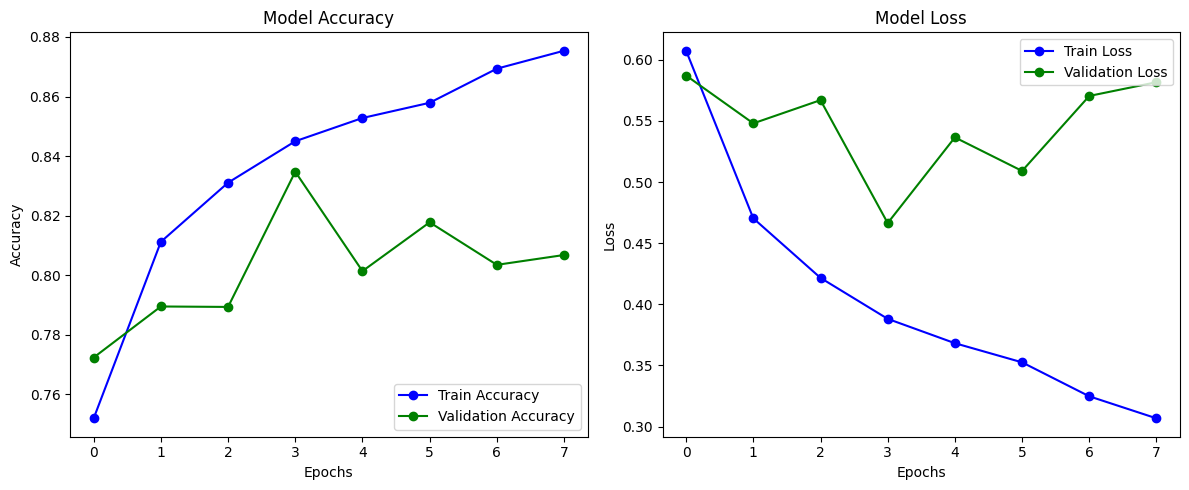

In [113]:
# Evaluate model
evaluate_model_on_test(model5, X_test_6, y_test_6, task_num=5)

# Plot training history
plot_accuracy_loss(model5_history.history)

In [103]:
X_train_5, y_train_5 = filter_data_by_classes(X_train, y_train, [5])

for i in range(len(X_train_5)):
    replay_buffer.push((X_train_5[i], y_train_5[i]))

In [104]:
train_histories.append(model5_history)

<h1> Task 6

In [105]:
num_classes = 7  # Introducing the third class
model6 = extend_output_layer(model5, num_classes)

X_train_7, y_train_7 = filter_data_by_classes(X_train, y_train, [0,1,2,3,4,5,6])
X_val_7, y_val_7 = filter_data_by_classes(X_val, y_val, [0,1,2,3,4,5,6])
X_test_7, y_test_7 = filter_data_by_classes(X_test, y_test, [0,1,2,3,4,5,6])

In [106]:
print("New class added class 6")
model6_history = incremental_learning_separate(model6, replay_buffer, batch_size=32, epochs=20, 
                                         train_histories=train_histories, new_data=(X_train_7, y_train_7), 
                                         X_val=X_val_7, y_val=y_val_7)

New class added class 6
Epoch 1/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6021 - loss: 1.0578 - val_accuracy: 0.7425 - val_loss: 0.6487
Epoch 2/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7579 - loss: 0.6578 - val_accuracy: 0.7823 - val_loss: 0.5782
Epoch 3/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7687 - loss: 0.6108 - val_accuracy: 0.7397 - val_loss: 0.6761
Epoch 4/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7805 - loss: 0.5873 - val_accuracy: 0.7844 - val_loss: 0.5791
Epoch 5/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7875 - loss: 0.5655 - val_accuracy: 0.7767 - val_loss: 0.6000
Epoch 6/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7883 - loss: 0.5577 - val_accuracy: 0.7898 - val_loss: 0.5664
Epoch 7/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7953 - loss: 0.5474 - val_accuracy: 0.7743 - val_loss: 0.6425
Epoch 8/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy:

423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification report for Task 6:
              precision    recall  f1-score   support

     Class 0       0.93      0.94      0.93      1840
     Class 1       0.94      0.94      0.94      2006
     Class 2       0.66      0.69      0.68      1994
     Class 3       0.89      0.89      0.89      2071
     Class 4       0.72      0.69      0.70      1583
     Class 5       0.77      0.79      0.78      2441
     Class 6       0.80      0.74      0.77      1582

    accuracy                           0.82     13517
   macro avg       0.81      0.81      0.81     13517
weighted avg       0.82      0.82      0.82     13517



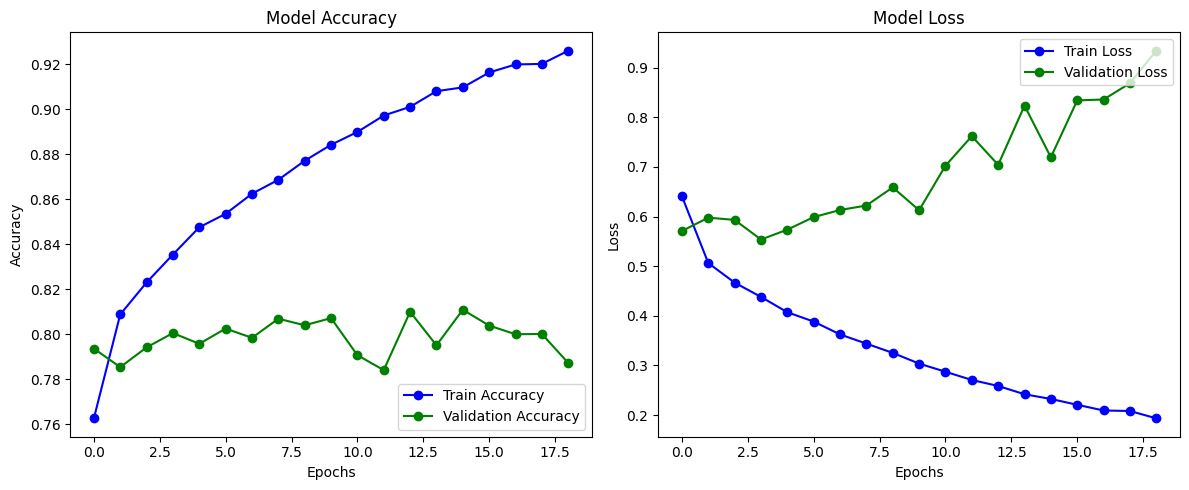

In [118]:
# Evaluate model
evaluate_model_on_test(model6, X_test_7, y_test_7, task_num=6)

# Plot training history
plot_accuracy_loss(model6_history.history)

In [107]:
X_train_6, y_train_6 = filter_data_by_classes(X_train, y_train, [6])

for i in range(len(X_train_6)):
    replay_buffer.push((X_train_6[i], y_train_6[i]))

In [108]:
train_histories.append(model6_history)

<h1> Task 7

In [116]:
num_classes = 8  # Introducing the third class
model7 = extend_output_layer(model6, num_classes)

X_train_8, y_train_8 = filter_data_by_classes(X_train, y_train, [0,1,2,3,4,5,6,7])
X_val_8, y_val_8 = filter_data_by_classes(X_val, y_val, [0,1,2,3,4,5,6,7])
X_test_8, y_test_8 = filter_data_by_classes(X_test, y_test, [0,1,2,3,4,5,6,7])

In [117]:
print("New class added class 7")
model7_history = incremental_learning_separate(model7, replay_buffer, batch_size=32, epochs=20, 
                                         train_histories=train_histories, new_data=(X_train_8, y_train_8), 
                                         X_val=X_val_8, y_val=y_val_8)

New class added class 7
Epoch 1/20
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.6719 - loss: 0.8871 - val_accuracy: 0.7446 - val_loss: 0.6832
Epoch 2/20
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7857 - loss: 0.5554 - val_accuracy: 0.7450 - val_loss: 0.6672
Epoch 3/20
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7832 - loss: 0.5495 - val_accuracy: 0.7542 - val_loss: 0.6605
Epoch 4/20
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7897 - loss: 0.5342 - val_accuracy: 0.7341 - val_loss: 0.7231
Epoch 5/20
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7891 - loss: 0.5302 - val_accuracy: 0.7537 - val_loss: 0.6843
Epoch 6/20
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7896 - loss: 0.5398 - val_accuracy: 0.7627 - val_loss: 0.6454
Epoch 7/20
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7949 - loss: 0.5175 - val_accuracy: 0.7600 - val_loss: 0.6505
Epoch 8/20
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy:

1928/1928 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification report for Task 7:
              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.97      7526
     Class 1       0.97      0.97      0.97      7503
     Class 2       0.72      0.75      0.73      8366
     Class 3       0.94      0.95      0.95      8330
     Class 4       0.75      0.84      0.79      6423
     Class 5       0.79      0.63      0.70      9741
     Class 6       0.90      0.81      0.85      6304
     Class 7       0.57      0.68      0.62      7497

    accuracy                           0.82     61690
   macro avg       0.83      0.82      0.82     61690
weighted avg       0.83      0.82      0.82     61690



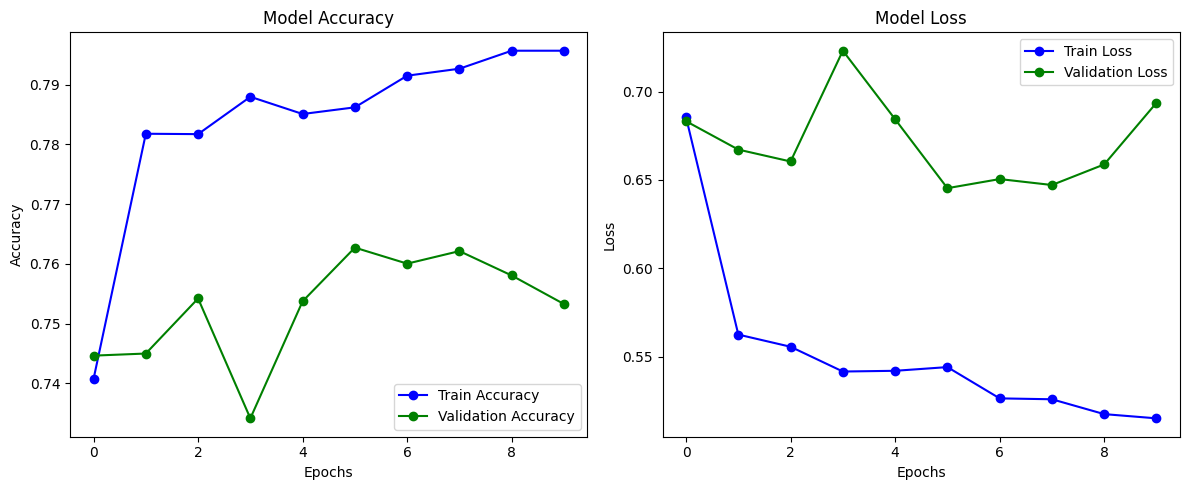

In [118]:
# Evaluate model
evaluate_model_on_test(model7, X_train_8, y_train_8, task_num=7)

# Plot training history
plot_accuracy_loss(model7_history.history)

In [119]:
X_train_7, y_train_7 = filter_data_by_classes(X_train, y_train, [7])

for i in range(len(X_train_7)):
    replay_buffer.push((X_train_7[i], y_train_7[i]))

In [120]:
train_histories.append(model7_history)

<h1> Task 8

In [126]:
num_classes = 9  # Introducing the third class
model8 = extend_output_layer(model7, num_classes)

X_train_9, y_train_9 = filter_data_by_classes(X_train, y_train, [0,1,2,3,4,5,6,7,8])
X_val_9, y_val_9 = filter_data_by_classes(X_val, y_val, [0,1,2,3,4,5,6,7,8])
X_test_9, y_test_9 = filter_data_by_classes(X_test, y_test, [0,1,2,3,4,5,6,7,8])

In [127]:
print("New class added class 8")
model8_history = incremental_learning_separate(model8, replay_buffer, batch_size=32, epochs=10, 
                                         train_histories=train_histories, new_data=(X_train_9, y_train_9), 
                                         X_val=X_val_9, y_val=y_val_9)

New class added class 8
Epoch 1/10
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6551 - loss: 0.9058 - val_accuracy: 0.7060 - val_loss: 0.9254
Epoch 2/10
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7862 - loss: 0.5258 - val_accuracy: 0.7086 - val_loss: 0.9404
Epoch 3/10
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8010 - loss: 0.4910 - val_accuracy: 0.6985 - val_loss: 0.9640
Epoch 4/10
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8127 - loss: 0.4627 - val_accuracy: 0.7026 - val_loss: 0.9902
Epoch 5/10
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8195 - loss: 0.4452 - val_accuracy: 0.7091 - val_loss: 1.0255
Epoch 6/10
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8258 - loss: 0.4296 - val_accuracy: 0.7014 - val_loss: 1.0725
Epoch 7/10
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8310 - loss: 0.4151 - val_accuracy: 0.6809 - val_loss: 1.1488
Epoch 8/10
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy:

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

Classification report for Task 8:
              precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00      7526
     Class 1       0.97      0.99      0.98      7503
     Class 2       0.81      0.80      0.81      8366
     Class 3       0.86      1.00      0.93      8330
     Class 4       0.90      0.97      0.93      6423
     Class 5       0.87      0.76      0.81      9741
     Class 6       0.92      0.96      0.94      6304
     Class 7       0.68      0.71      0.70      7497
     Class 8       0.86      0.76      0.81     10306

    accuracy                           0.87     71996
   macro avg       0.88      0.88      0.88     71996
weighted avg       0.87      0.87      0.87     71996



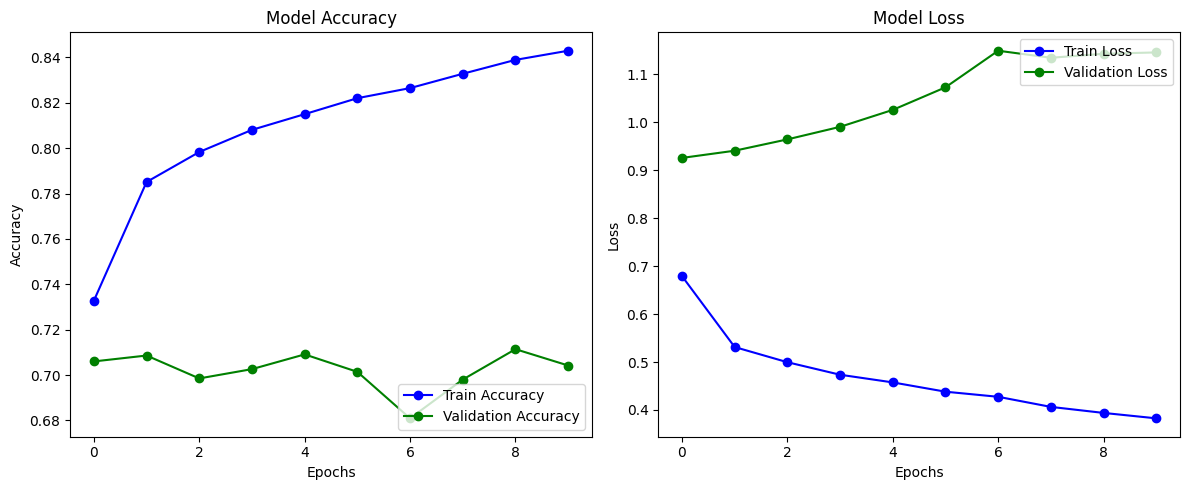

In [134]:
# Evaluate model
evaluate_model_on_test(model8, X_train_9, y_train_9, task_num=8)

# Plot training history
plot_accuracy_loss(model8_history.history)

In [129]:
X_train_8, y_train_8 = filter_data_by_classes(X_train, y_train, [8])

for i in range(len(X_train_8)):
    replay_buffer.push((X_train_8[i], y_train_8[i]))

In [130]:
train_histories.append(model8_history)

<h1> Final Model Experiments

In [121]:
import optuna
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import tensorflow as tf

def create_model(num_classes, input_shape=(28,28,1), trial=None):
    # Sample hyperparameters from the trial
    filters_1 = trial.suggest_int('filters_1', 16, 64, step=16)
    filters_2 = trial.suggest_int('filters_2', 32, 128, step=32)
    filters_3 = trial.suggest_int('filters_3', 64, 256, step=64)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)

    model = models.Sequential([
        layers.Conv2D(filters_1, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters_2, (kernel_size, kernel_size), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters_3, (kernel_size, kernel_size), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


def objective(trial):
    # Sample hyperparameters
    num_classes = 14  # Change this as per your dataset
    input_shape = (28, 28, 1)

    # Create the model with the sampled hyperparameters
    model = create_model(num_classes, input_shape, trial)

    # Train the model with early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Use a portion of the training data for validation
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, 
                        callbacks=[early_stopping], verbose=1)

    # Return the validation accuracy for optimization
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Create an Optuna study to optimize the hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # You can increase n_trials for more exhaustive search

# Best hyperparameters found by Optuna
print(f"Best hyperparameters: {study.best_params}")


[I 2024-11-09 15:23:39,035] A new study created in memory with name: no-name-e3f0c72f-cca7-4f1e-a9c7-0ac27e7a7d4b


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.2647 - loss: 1.9612 - val_accuracy: 0.5600 - val_loss: 1.2201
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5355 - loss: 1.2469 - val_accuracy: 0.6023 - val_loss: 1.0767
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5806 - loss: 1.1187 - val_accuracy: 0.6279 - val_loss: 1.0102
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6103 - loss: 1.0519 - val_accuracy: 0.6325 - val_loss: 0.9869
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6259 - loss: 1.0023 - val_accuracy: 0.6465 - val_loss: 0.9296
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6422 - loss: 0.9663 - val_accuracy: 0.6706 - val_loss: 0.8690
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6567 - loss: 0.9205 - val_accuracy: 0.6884 - val_loss: 0.8360
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6717 - loss: 0.8953 

[I 2024-11-09 15:25:12,189] Trial 0 finished with value: 0.7033186554908752 and parameters: {'filters_1': 64, 'filters_2': 96, 'filters_3': 64, 'kernel_size': 5, 'dropout_rate': 0.30300541570278244, 'learning_rate': 8.493660696632064e-05}. Best is trial 0 with value: 0.7033186554908752.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.3469 - loss: 1.7373 - val_accuracy: 0.5620 - val_loss: 1.2357
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5887 - loss: 1.1016 - val_accuracy: 0.6241 - val_loss: 0.9963
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6290 - loss: 0.9875 - val_accuracy: 0.6582 - val_loss: 0.8817
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6642 - loss: 0.9034 - val_accuracy: 0.7075 - val_loss: 0.7908
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7096 - loss: 0.7890 - val_accuracy: 0.7623 - val_loss: 0.6418
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7348 - loss: 0.7260 - val_accuracy: 0.7620 - val_loss: 0.6319
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7598 - loss: 0.6613 - val_accuracy: 0.7759 - val_loss: 0.5899
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7764 - loss: 0.6174 -

[I 2024-11-09 15:26:28,294] Trial 1 finished with value: 0.8173730373382568 and parameters: {'filters_1': 64, 'filters_2': 32, 'filters_3': 192, 'kernel_size': 3, 'dropout_rate': 0.31038687378844737, 'learning_rate': 0.0004147165251095789}. Best is trial 1 with value: 0.8173730373382568.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.3175 - loss: 1.8116 - val_accuracy: 0.5727 - val_loss: 1.1410
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5686 - loss: 1.1525 - val_accuracy: 0.6012 - val_loss: 1.0457
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6094 - loss: 1.0476 - val_accuracy: 0.6435 - val_loss: 0.9306
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6347 - loss: 0.9755 - val_accuracy: 0.6657 - val_loss: 0.9010
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6705 - loss: 0.8880 - val_accuracy: 0.6998 - val_loss: 0.7994
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6869 - loss: 0.8439 - val_accuracy: 0.7171 - val_loss: 0.7563
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7111 - loss: 0.7806 - val_accuracy: 0.6930 - val_loss: 0.8084
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7281 - loss: 0.7455 -

[I 2024-11-09 15:27:35,219] Trial 2 finished with value: 0.73870450258255 and parameters: {'filters_1': 16, 'filters_2': 32, 'filters_3': 128, 'kernel_size': 5, 'dropout_rate': 0.20978155584018918, 'learning_rate': 0.00029501576786020525}. Best is trial 1 with value: 0.8173730373382568.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.1795 - loss: 2.1968 - val_accuracy: 0.3939 - val_loss: 1.6509
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3739 - loss: 1.6699 - val_accuracy: 0.4652 - val_loss: 1.4477
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4663 - loss: 1.4463 - val_accuracy: 0.5482 - val_loss: 1.2632
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5223 - loss: 1.2928 - val_accuracy: 0.5246 - val_loss: 1.2766
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5448 - loss: 1.2192 - val_accuracy: 0.5753 - val_loss: 1.1517
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5556 - loss: 1.1952 - val_accuracy: 0.5721 - val_loss: 1.1422
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5627 - loss: 1.1663 - val_accuracy: 0.5987 - val_loss: 1.0756
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5742 - loss: 1.1379 -

[I 2024-11-09 15:28:48,276] Trial 3 finished with value: 0.5980607867240906 and parameters: {'filters_1': 64, 'filters_2': 32, 'filters_3': 64, 'kernel_size': 5, 'dropout_rate': 0.38228865582025506, 'learning_rate': 3.052785123512511e-05}. Best is trial 1 with value: 0.8173730373382568.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.2860 - loss: 1.9102 - val_accuracy: 0.5473 - val_loss: 1.2154
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5270 - loss: 1.2644 - val_accuracy: 0.5854 - val_loss: 1.0818
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5672 - loss: 1.1586 - val_accuracy: 0.5959 - val_loss: 1.0500
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5933 - loss: 1.0895 - val_accuracy: 0.6210 - val_loss: 0.9838
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6122 - loss: 1.0310 - val_accuracy: 0.6448 - val_loss: 0.9530
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6268 - loss: 1.0033 - val_accuracy: 0.6343 - val_loss: 0.9771
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6458 - loss: 0.9505 - val_accuracy: 0.6634 - val_loss: 0.8657
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6612 - loss: 0.9199 -

[I 2024-11-09 15:30:04,104] Trial 4 finished with value: 0.7190123796463013 and parameters: {'filters_1': 48, 'filters_2': 32, 'filters_3': 256, 'kernel_size': 3, 'dropout_rate': 0.322844541503835, 'learning_rate': 0.00013558264692326667}. Best is trial 1 with value: 0.8173730373382568.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.2900 - loss: 1.8656 - val_accuracy: 0.5517 - val_loss: 1.1713
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5580 - loss: 1.1822 - val_accuracy: 0.6438 - val_loss: 0.9707
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6303 - loss: 1.0113 - val_accuracy: 0.6845 - val_loss: 0.8262
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6676 - loss: 0.9086 - val_accuracy: 0.6780 - val_loss: 0.8410
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7012 - loss: 0.8217 - val_accuracy: 0.7526 - val_loss: 0.6938
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7316 - loss: 0.7424 - val_accuracy: 0.7602 - val_loss: 0.6379
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7604 - loss: 0.6619 - val_accuracy: 0.7788 - val_loss: 0.5897
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7743 - loss: 0.6187 -

[I 2024-11-09 15:31:43,954] Trial 5 finished with value: 0.8093762397766113 and parameters: {'filters_1': 48, 'filters_2': 64, 'filters_3': 256, 'kernel_size': 4, 'dropout_rate': 0.3547960499592018, 'learning_rate': 0.0005396545240501284}. Best is trial 1 with value: 0.8173730373382568.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.3110 - loss: 1.8377 - val_accuracy: 0.5594 - val_loss: 1.1639
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5722 - loss: 1.1436 - val_accuracy: 0.6375 - val_loss: 0.9800
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6305 - loss: 0.9961 - val_accuracy: 0.6916 - val_loss: 0.8102
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6783 - loss: 0.8775 - val_accuracy: 0.7033 - val_loss: 0.7802
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7093 - loss: 0.7959 - val_accuracy: 0.7392 - val_loss: 0.7037
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7281 - loss: 0.7443 - val_accuracy: 0.7564 - val_loss: 0.6595
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7457 - loss: 0.6969 - val_accuracy: 0.7735 - val_loss: 0.6058
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7620 - loss: 0.6540 -

[I 2024-11-09 15:33:03,344] Trial 6 finished with value: 0.8023790717124939 and parameters: {'filters_1': 64, 'filters_2': 64, 'filters_3': 64, 'kernel_size': 4, 'dropout_rate': 0.2765730681994346, 'learning_rate': 0.0002795547151766715}. Best is trial 1 with value: 0.8173730373382568.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.2007 - loss: 2.1450 - val_accuracy: 0.4161 - val_loss: 1.5898
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4306 - loss: 1.5401 - val_accuracy: 0.5204 - val_loss: 1.3278
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5111 - loss: 1.3275 - val_accuracy: 0.5577 - val_loss: 1.2041
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5472 - loss: 1.2322 - val_accuracy: 0.5519 - val_loss: 1.1819
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5576 - loss: 1.1844 - val_accuracy: 0.5873 - val_loss: 1.0998
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5687 - loss: 1.1562 - val_accuracy: 0.5803 - val_loss: 1.1070
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5834 - loss: 1.1185 - val_accuracy: 0.5688 - val_loss: 1.1321
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5896 - loss: 1.0894 -

[I 2024-11-09 15:34:43,240] Trial 7 finished with value: 0.618552565574646 and parameters: {'filters_1': 48, 'filters_2': 64, 'filters_3': 256, 'kernel_size': 4, 'dropout_rate': 0.21837483660140397, 'learning_rate': 2.8489452642929545e-05}. Best is trial 1 with value: 0.8173730373382568.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.2174 - loss: 2.0853 - val_accuracy: 0.4412 - val_loss: 1.4996
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4606 - loss: 1.4713 - val_accuracy: 0.5401 - val_loss: 1.2501
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5149 - loss: 1.3000 - val_accuracy: 0.5532 - val_loss: 1.1750
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5430 - loss: 1.2184 - val_accuracy: 0.5835 - val_loss: 1.1149
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5579 - loss: 1.1797 - val_accuracy: 0.5774 - val_loss: 1.1084
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5697 - loss: 1.1420 - val_accuracy: 0.5939 - val_loss: 1.0792
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5774 - loss: 1.1256 - val_accuracy: 0.6045 - val_loss: 1.0332
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5906 - loss: 1.0855 -

[I 2024-11-09 15:35:53,093] Trial 8 finished with value: 0.6310476064682007 and parameters: {'filters_1': 32, 'filters_2': 32, 'filters_3': 192, 'kernel_size': 4, 'dropout_rate': 0.27005514766401384, 'learning_rate': 5.211835642072245e-05}. Best is trial 1 with value: 0.8173730373382568.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.3346 - loss: 1.7761 - val_accuracy: 0.5497 - val_loss: 1.1779
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5603 - loss: 1.1611 - val_accuracy: 0.6295 - val_loss: 0.9954
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6168 - loss: 1.0379 - val_accuracy: 0.6620 - val_loss: 0.8965
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6459 - loss: 0.9541 - val_accuracy: 0.6883 - val_loss: 0.8283
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6783 - loss: 0.8768 - val_accuracy: 0.7047 - val_loss: 0.7784
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7047 - loss: 0.8141 - val_accuracy: 0.7359 - val_loss: 0.7086
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7204 - loss: 0.7704 - val_accuracy: 0.7399 - val_loss: 0.6851
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7434 - loss: 0.7128 -

[I 2024-11-09 15:36:57,162] Trial 9 finished with value: 0.7755897641181946 and parameters: {'filters_1': 16, 'filters_2': 64, 'filters_3': 64, 'kernel_size': 4, 'dropout_rate': 0.3940648079931217, 'learning_rate': 0.00027706660803949453}. Best is trial 1 with value: 0.8173730373382568.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.1278 - loss: 2.4328 - val_accuracy: 0.2618 - val_loss: 2.1147
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2300 - loss: 2.0912 - val_accuracy: 0.3419 - val_loss: 1.7926
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3062 - loss: 1.8770 - val_accuracy: 0.4433 - val_loss: 1.6368
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3740 - loss: 1.7214 - val_accuracy: 0.4651 - val_loss: 1.5094
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4159 - loss: 1.5894 - val_accuracy: 0.4877 - val_loss: 1.4230
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4491 - loss: 1.5053 - val_accuracy: 0.5145 - val_loss: 1.3743
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4655 - loss: 1.4400 - val_accuracy: 0.5293 - val_loss: 1.2980
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4883 - loss: 1.3894 -

[I 2024-11-09 15:38:16,058] Trial 10 finished with value: 0.5648740530014038 and parameters: {'filters_1': 32, 'filters_2': 128, 'filters_3': 192, 'kernel_size': 3, 'dropout_rate': 0.46882480037289254, 'learning_rate': 1.0437354850292637e-05}. Best is trial 1 with value: 0.8173730373382568.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.3862 - loss: 1.6325 - val_accuracy: 0.6087 - val_loss: 1.0212
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6188 - loss: 1.0262 - val_accuracy: 0.6929 - val_loss: 0.8261
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6940 - loss: 0.8362 - val_accuracy: 0.7521 - val_loss: 0.6532
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7430 - loss: 0.7155 - val_accuracy: 0.7684 - val_loss: 0.6645
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7667 - loss: 0.6449 - val_accuracy: 0.7858 - val_loss: 0.5638
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7869 - loss: 0.5837 - val_accuracy: 0.8002 - val_loss: 0.5254
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8106 - loss: 0.5173 - val_accuracy: 0.7941 - val_loss: 0.5622
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8238 - loss: 0.4786 -

[I 2024-11-09 15:39:44,559] Trial 11 finished with value: 0.8315673470497131 and parameters: {'filters_1': 48, 'filters_2': 96, 'filters_3': 256, 'kernel_size': 3, 'dropout_rate': 0.3711137163271416, 'learning_rate': 0.0009249294206922546}. Best is trial 11 with value: 0.8315673470497131.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.3632 - loss: 1.6963 - val_accuracy: 0.6002 - val_loss: 1.0385
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5891 - loss: 1.0997 - val_accuracy: 0.6811 - val_loss: 0.8388
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6634 - loss: 0.9144 - val_accuracy: 0.6519 - val_loss: 0.9251
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7100 - loss: 0.7983 - val_accuracy: 0.7530 - val_loss: 0.6607
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7387 - loss: 0.7160 - val_accuracy: 0.7456 - val_loss: 0.7101
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7615 - loss: 0.6605 - val_accuracy: 0.7558 - val_loss: 0.6670
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7774 - loss: 0.6139 - val_accuracy: 0.7809 - val_loss: 0.5810
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7896 - loss: 0.5746 -

[I 2024-11-09 15:41:11,733] Trial 12 finished with value: 0.8119751811027527 and parameters: {'filters_1': 64, 'filters_2': 96, 'filters_3': 192, 'kernel_size': 3, 'dropout_rate': 0.4403430156657868, 'learning_rate': 0.0009758132234938055}. Best is trial 11 with value: 0.8315673470497131.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.3645 - loss: 1.6972 - val_accuracy: 0.6274 - val_loss: 1.0042
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5976 - loss: 1.0841 - val_accuracy: 0.6542 - val_loss: 0.9402
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6733 - loss: 0.8920 - val_accuracy: 0.7452 - val_loss: 0.6944
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7191 - loss: 0.7741 - val_accuracy: 0.7586 - val_loss: 0.6374
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7510 - loss: 0.6831 - val_accuracy: 0.7453 - val_loss: 0.6760
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7717 - loss: 0.6307 - val_accuracy: 0.7958 - val_loss: 0.5368
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7924 - loss: 0.5756 - val_accuracy: 0.8062 - val_loss: 0.5205
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8017 - loss: 0.5447 -

[I 2024-11-09 15:42:29,078] Trial 13 finished with value: 0.8269692063331604 and parameters: {'filters_1': 48, 'filters_2': 128, 'filters_3': 128, 'kernel_size': 3, 'dropout_rate': 0.4074192558528462, 'learning_rate': 0.0008472257514999707}. Best is trial 11 with value: 0.8315673470497131.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.3556 - loss: 1.7155 - val_accuracy: 0.5961 - val_loss: 1.0690
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5803 - loss: 1.1230 - val_accuracy: 0.6553 - val_loss: 0.9140
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6538 - loss: 0.9436 - val_accuracy: 0.7123 - val_loss: 0.7786
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7061 - loss: 0.8132 - val_accuracy: 0.7702 - val_loss: 0.6190
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7397 - loss: 0.7128 - val_accuracy: 0.7842 - val_loss: 0.5725
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7622 - loss: 0.6555 - val_accuracy: 0.7852 - val_loss: 0.5728
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7792 - loss: 0.6094 - val_accuracy: 0.7837 - val_loss: 0.5673
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7950 - loss: 0.5613 -

[I 2024-11-09 15:43:42,037] Trial 14 finished with value: 0.8010795712471008 and parameters: {'filters_1': 32, 'filters_2': 128, 'filters_3': 128, 'kernel_size': 3, 'dropout_rate': 0.4214219850488511, 'learning_rate': 0.000910942696536651}. Best is trial 11 with value: 0.8315673470497131.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.2800 - loss: 1.9345 - val_accuracy: 0.5725 - val_loss: 1.1859
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5356 - loss: 1.2469 - val_accuracy: 0.6054 - val_loss: 1.0312
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5813 - loss: 1.1277 - val_accuracy: 0.6318 - val_loss: 0.9767
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6057 - loss: 1.0623 - val_accuracy: 0.6623 - val_loss: 0.8949
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6324 - loss: 0.9979 - val_accuracy: 0.6526 - val_loss: 0.9044
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6563 - loss: 0.9348 - val_accuracy: 0.7110 - val_loss: 0.7834
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6782 - loss: 0.8803 - val_accuracy: 0.7160 - val_loss: 0.7574
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6959 - loss: 0.8292 -

[I 2024-11-09 15:44:58,478] Trial 15 finished with value: 0.7630947828292847 and parameters: {'filters_1': 48, 'filters_2': 128, 'filters_3': 128, 'kernel_size': 3, 'dropout_rate': 0.4759593421877119, 'learning_rate': 0.00015496042982792723}. Best is trial 11 with value: 0.8315673470497131.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.3531 - loss: 1.7280 - val_accuracy: 0.5368 - val_loss: 1.2241
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5711 - loss: 1.1468 - val_accuracy: 0.6422 - val_loss: 0.9360
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6299 - loss: 0.9940 - val_accuracy: 0.7182 - val_loss: 0.7612
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6876 - loss: 0.8605 - val_accuracy: 0.7336 - val_loss: 0.7145
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7217 - loss: 0.7666 - val_accuracy: 0.7086 - val_loss: 0.7649
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7540 - loss: 0.6829 - val_accuracy: 0.7282 - val_loss: 0.7249
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7834 - loss: 0.6051 - val_accuracy: 0.7749 - val_loss: 0.5986
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7947 - loss: 0.5587 -

[I 2024-11-09 15:46:11,840] Trial 16 finished with value: 0.8357657194137573 and parameters: {'filters_1': 48, 'filters_2': 96, 'filters_3': 128, 'kernel_size': 3, 'dropout_rate': 0.3875643884031709, 'learning_rate': 0.0006579825245736114}. Best is trial 16 with value: 0.8357657194137573.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.3860 - loss: 1.6417 - val_accuracy: 0.5930 - val_loss: 1.0758
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6286 - loss: 1.0040 - val_accuracy: 0.7167 - val_loss: 0.7705
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6921 - loss: 0.8487 - val_accuracy: 0.7569 - val_loss: 0.6729
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7374 - loss: 0.7217 - val_accuracy: 0.7739 - val_loss: 0.6079
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7647 - loss: 0.6410 - val_accuracy: 0.7894 - val_loss: 0.5525
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7900 - loss: 0.5771 - val_accuracy: 0.7891 - val_loss: 0.5751
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8041 - loss: 0.5409 - val_accuracy: 0.8222 - val_loss: 0.4763
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8213 - loss: 0.4923 -

[I 2024-11-09 15:47:33,912] Trial 17 finished with value: 0.8364654183387756 and parameters: {'filters_1': 32, 'filters_2': 96, 'filters_3': 256, 'kernel_size': 3, 'dropout_rate': 0.3543144447804628, 'learning_rate': 0.0006750649200608114}. Best is trial 17 with value: 0.8364654183387756.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.3424 - loss: 1.7544 - val_accuracy: 0.5953 - val_loss: 1.0537
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5882 - loss: 1.1012 - val_accuracy: 0.6465 - val_loss: 0.9263
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6581 - loss: 0.9299 - val_accuracy: 0.7464 - val_loss: 0.7004
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7111 - loss: 0.7950 - val_accuracy: 0.7510 - val_loss: 0.6685
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7495 - loss: 0.6984 - val_accuracy: 0.7834 - val_loss: 0.5613
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7742 - loss: 0.6239 - val_accuracy: 0.8050 - val_loss: 0.5049
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7913 - loss: 0.5786 - val_accuracy: 0.8038 - val_loss: 0.5184
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8118 - loss: 0.5167 -

[I 2024-11-09 15:48:50,522] Trial 18 finished with value: 0.8152738809585571 and parameters: {'filters_1': 32, 'filters_2': 96, 'filters_3': 192, 'kernel_size': 3, 'dropout_rate': 0.340928598982541, 'learning_rate': 0.00048489423728685687}. Best is trial 17 with value: 0.8364654183387756.


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.3106 - loss: 1.8695 - val_accuracy: 0.5780 - val_loss: 1.1431
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5510 - loss: 1.2049 - val_accuracy: 0.6129 - val_loss: 1.0180
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5970 - loss: 1.0985 - val_accuracy: 0.6300 - val_loss: 0.9640
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6277 - loss: 1.0094 - val_accuracy: 0.6906 - val_loss: 0.8364
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6632 - loss: 0.9191 - val_accuracy: 0.6989 - val_loss: 0.8020
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6918 - loss: 0.8556 - val_accuracy: 0.7157 - val_loss: 0.7536
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7098 - loss: 0.8066 - val_accuracy: 0.7171 - val_loss: 0.7464
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7261 - loss: 0.7561 -

[I 2024-11-09 15:50:06,545] Trial 19 finished with value: 0.7621951103210449 and parameters: {'filters_1': 16, 'filters_2': 96, 'filters_3': 128, 'kernel_size': 4, 'dropout_rate': 0.44200482178130546, 'learning_rate': 0.00019579986943317275}. Best is trial 17 with value: 0.8364654183387756.


Best hyperparameters: {'filters_1': 32, 'filters_2': 96, 'filters_3': 256, 'kernel_size': 3, 'dropout_rate': 0.3543144447804628, 'learning_rate': 0.0006750649200608114}


In [ ]:
print("done")